# Homework 5

## Wenting Su, ws2512
## Kewei Liu, kl2987

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("data/hw5_data_train.csv")
test = pd.read_csv("data/hw5_data_test.csv")

In [3]:
y_train = train['Recommended']
y_test = test['Recommended']

In [4]:
train.head()

,Title,Review,Recommended
0,Beautiful unique dress,Wore this to my sons wedding. found it last mi...,1
1,Had high hopes but...,"Gals, if you absolutely must have this top wai...",0
2,Buttons -buttons so cute!,I hardly believe i have not reviewed htis yet....,1
3,Love this dress,This dress is so cute and comfortable. i'm nor...,1
4,Perfect summer pants!,The linen- cotton blend breathes so well for a...,1


## Task 1 Title and Body

In [5]:
train.fillna('', inplace = True)
test.fillna('', inplace = True)

In [6]:
# use the title only
train['Title'] = train['Title'].str.lower()
train['Title'] = train['Title'].str.replace(r'[^0-9a-z]+', ' ')

test['Title'] = test['Title'].str.lower()
test['Title'] = test['Title'].str.replace(r'[^0-9a-z]+', ' ')

In [7]:
# use the review body only
train['Review'] = train['Review'].str.lower()
train['Review'] = train['Review'].str.replace(r'[^0-9a-z]+', ' ')

test['Review'] = test['Review'].str.lower()
test['Review'] = test['Review'].str.replace(r'[^0-9a-z]+', ' ')

In [8]:
# Concatenate the title and review to a single text 
train['Both'] = train['Title'] + ' ' + train['Review']
test['Both'] = test['Title'] + ' ' + test['Review']

#### Without regularization parameter tuning:

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pipe_1 = make_pipeline(CountVectorizer(), LogisticRegression(), memory="cache_folder")
print("AUC score for option 1: ", np.mean(cross_val_score(pipe_1, train['Title'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for option 1:  0.890804313375


In [10]:
# Visualize the 20 most important features
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

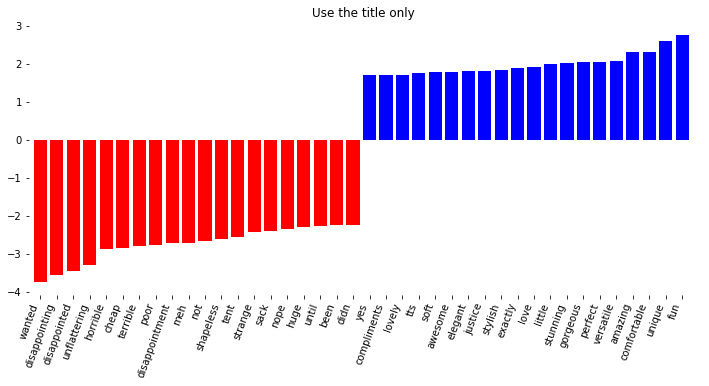

In [11]:
pipe_1.fit(train['Title'], y_train)
coef = pipe_1.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_1.named_steps['countvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use the title only");

In [12]:
pipe_2 = make_pipeline(CountVectorizer(), LogisticRegression(), memory="cache_folder")
print("AUC score for option 2: ", np.mean(cross_val_score(pipe_2, train['Review'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for option 2:  0.912376800502


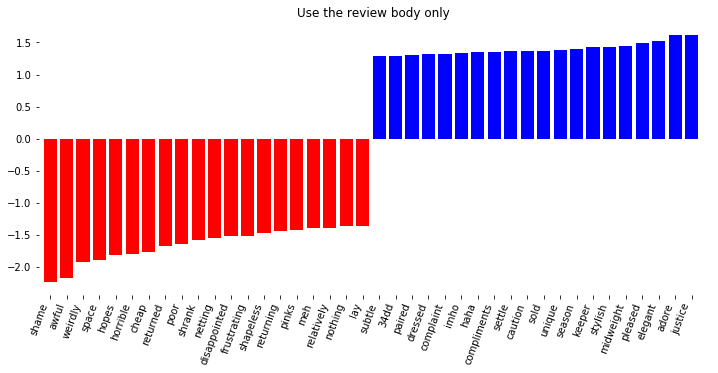

In [13]:
pipe_2.fit(train['Review'], y_train)
coef = pipe_2.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_2.named_steps['countvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use the review body only");

In [14]:
pipe_3 = make_pipeline(CountVectorizer(), LogisticRegression(), memory="cache_folder")
print("AUC score for option 3: ", np.mean(cross_val_score(pipe_3, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for option 3:  0.931061097864


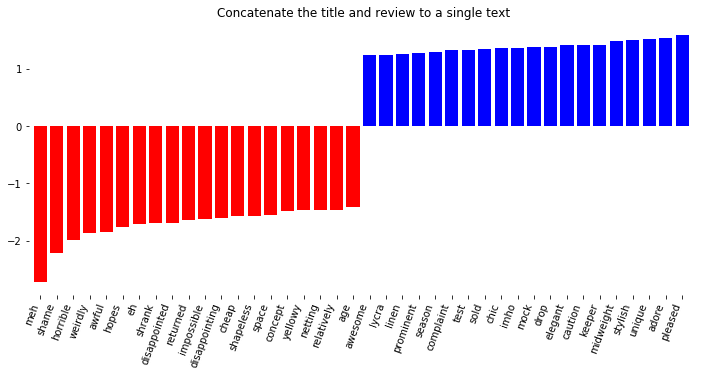

In [15]:
pipe_3.fit(train['Both'], y_train)
coef = pipe_3.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_3.named_steps['countvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Concatenate the title and review to a single text");

In [16]:
from scipy.sparse import hstack
# fitting on the traning set + validation set 
# won't result in leaking information as long as 
# we don't use statistics like max_df
vect_title = CountVectorizer()
vect_review = CountVectorizer()
train_title = vect_title.fit_transform(train['Title'])
train_review = vect_review.fit_transform(train['Review'])
train_vect = hstack([train_title, train_review])

lr = LogisticRegression()
print("AUC score for option 4: ", np.mean(cross_val_score(lr, train_vect, y_train, scoring = 'roc_auc', cv = 5)))

AUC score for option 4:  0.934076871502


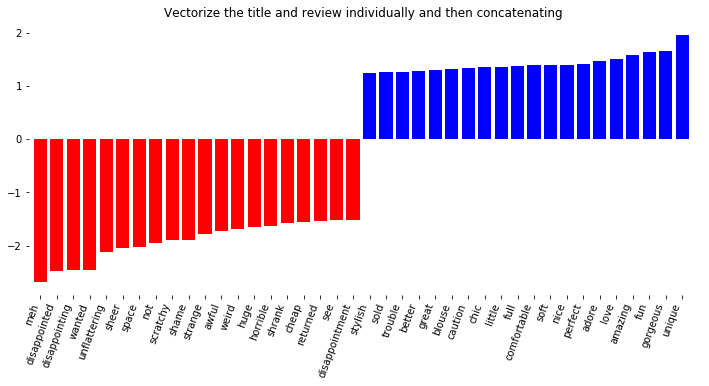

In [17]:
lr.fit(train_vect, y_train)
coef = lr.coef_.ravel()
features = np.array(vect_title.get_feature_names() + vect_review.get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Vectorize the title and review individually and then concatenating");

#### With regularization parameter tuning:

In [18]:
from sklearn.model_selection import GridSearchCV

param_123 = {'logisticregression__C': np.logspace(-3, 2, 11)}
pipe_grid = make_pipeline(CountVectorizer(), LogisticRegression(), memory="cache_folder")  
grid_123 = GridSearchCV(pipe_grid, param_123, 'roc_auc', cv=5)

In [19]:
grid_123.fit(train['Title'], y_train)
print("Best regularization parameter: ", grid_123.best_params_['logisticregression__C'])
print("AUC score for option 1 after tuning the regularization parameter: ", grid_123.best_score_)

Best regularization parameter:  1.0
AUC score for option 1 after tuning the regularization parameter:  0.890804079386


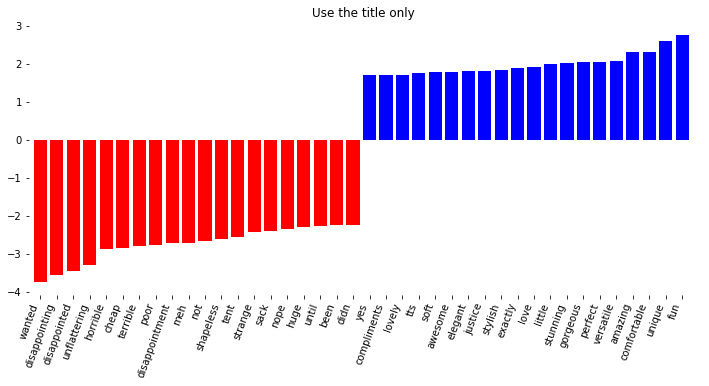

In [20]:
pipe_grid.set_params(**grid_123.best_params_).fit(train['Title'], y_train)
coef = pipe_grid.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_grid.named_steps['countvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use the title only");

In [21]:
%%time
grid_123.fit(train['Review'], y_train)
print("Best regularization parameter: ", grid_123.best_params_['logisticregression__C'])
print("AUC score for option 2 after tuning the regularization parameter: ", grid_123.best_score_)

Best regularization parameter:  0.1
AUC score for option 2 after tuning the regularization parameter:  0.923458409135
CPU times: user 1min 20s, sys: 1.46 s, total: 1min 22s
Wall time: 1min 23s


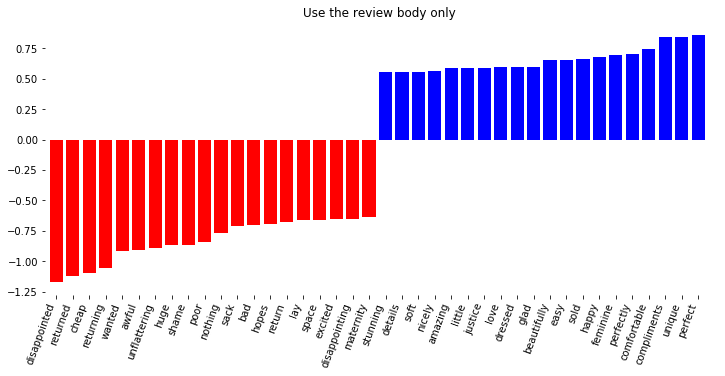

In [22]:
pipe_grid.set_params(**grid_123.best_params_).fit(train['Review'], y_train)
coef = pipe_grid.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_grid.named_steps['countvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use the review body only");

In [23]:
%%time
grid_123.fit(train['Both'], y_train)
print("Best regularization parameter: ", grid_123.best_params_['logisticregression__C'])
print("AUC score for option 3 after tuning the regularization parameter: ", grid_123.best_score_)

Best regularization parameter:  0.1
AUC score for option 3 after tuning the regularization parameter:  0.939879724023
CPU times: user 1min 18s, sys: 1.3 s, total: 1min 19s
Wall time: 1min 20s


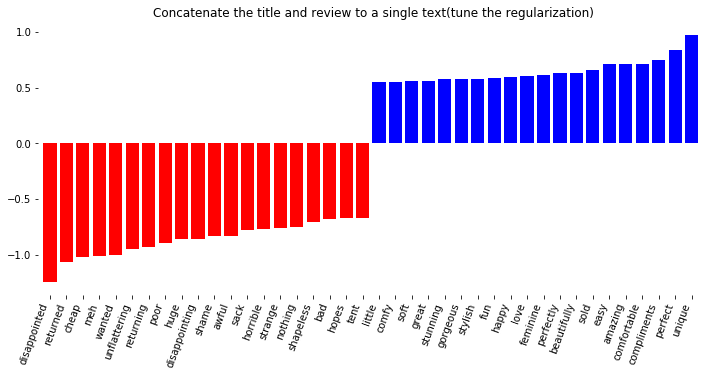

In [24]:
pipe_grid.set_params(**grid_123.best_params_).fit(train['Both'], y_train)
coef = pipe_grid.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_grid.named_steps['countvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Concatenate the title and review to a single text(tune the regularization)");

In [25]:
%%time
params = {'C': np.logspace(-3, 2, 11)}
lr = LogisticRegression()
grid_4 = GridSearchCV(lr, params, 'roc_auc', cv=5)
grid_4.fit(train_vect, y_train)
print("Best regularization parameter: ", grid_4.best_params_['C'])
print("AUC score for option 4 after tuning the regularization parameter: ", grid_4.best_score_)

Best regularization parameter:  0.1
AUC score for option 4 after tuning the regularization parameter:  0.940126885521
CPU times: user 25 s, sys: 221 ms, total: 25.3 s
Wall time: 25.3 s


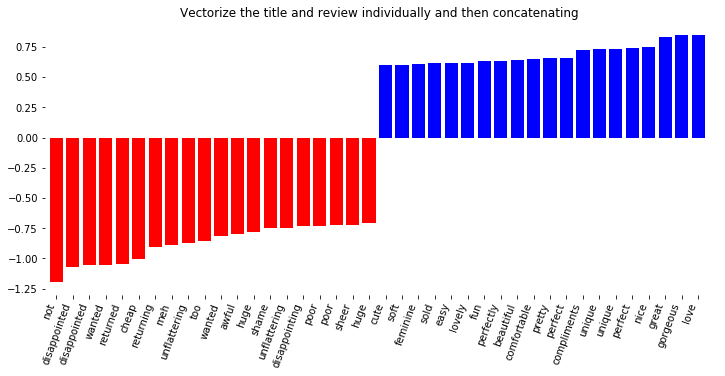

In [26]:
lr.set_params(**grid_4.best_params_).fit(train_vect, y_train)
coef = lr.coef_.ravel()
features = np.array(vect_title.get_feature_names() + vect_review.get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Vectorize the title and review individually and then concatenating");

From the above results, we can see that option 4 works best.

Evaluate the best model using the test set

In [27]:
test_title = vect_title.transform(test['Title'])
test_review = vect_review.transform(test['Review'])
test_vect = hstack([test_title, test_review])

In [28]:
from sklearn.metrics import roc_auc_score
y_pred = lr.predict_proba(test_vect)[:, 1]
print("AUC score of test set for option 4: ", roc_auc_score(y_test, y_pred))

AUC score of test set for option 4:  0.937525897686


For the simplicity, for the remaining tasks, we will work with option 3), concatenating the texts.

## Task 2 Feature Tuning

### 2.1

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
pipe_tfidf = make_pipeline(TfidfVectorizer(), LogisticRegression(), memory="cache_folder")
print("AUC score for TfidfVectorizer: ", np.mean(cross_val_score(pipe_tfidf, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for TfidfVectorizer:  0.947237939523


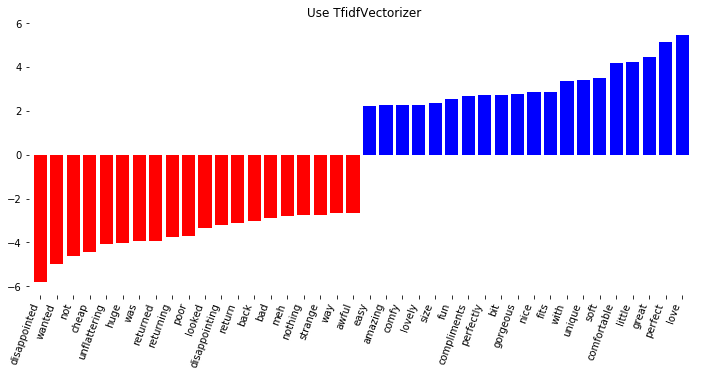

In [30]:
pipe_tfidf.fit(train['Both'], y_train)
coef = pipe_tfidf.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf.named_steps['tfidfvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use TfidfVectorizer");

Comparing with the results in task 1, we can see that using TfidfVectorizer improved the AUC score and made important coefficients much larger.

### 2.2

In [31]:
from sklearn.preprocessing import Normalizer
pipe_norm = make_pipeline(CountVectorizer(), Normalizer(), LogisticRegression(), memory="cache_folder")
print("AUC score for CountVectorizer and Normalizer: ", np.mean(cross_val_score(pipe_norm, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for CountVectorizer and Normalizer:  0.936042478757


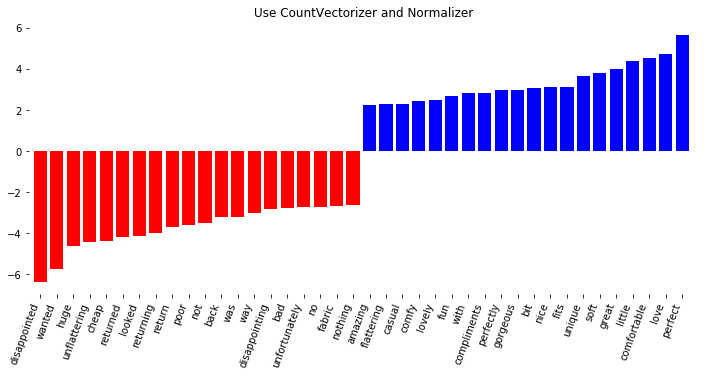

In [32]:
pipe_norm.fit(train['Both'], y_train)
coef = pipe_norm.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_norm.named_steps['countvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use CountVectorizer and Normalizer");

The results above shows that using a Normalizer with CountVectorizer changed the outcome and made the important coefficients much larger. However, its performance, measured by AUC score, was still worse than using TfidfVectorizer.

### 2.3

Among previous models, the one using TfidfVectorizer worked best on the concatenated texts. So now we'll try using TfidfVectorizer with standard English stop-word.

In [33]:
pipe_tfidf_sw = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression(), memory="cache_folder")
print("AUC score for TfidfVectorizer with stop-words: ", np.mean(cross_val_score(pipe_tfidf_sw, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for TfidfVectorizer with stop-words:  0.93932418055


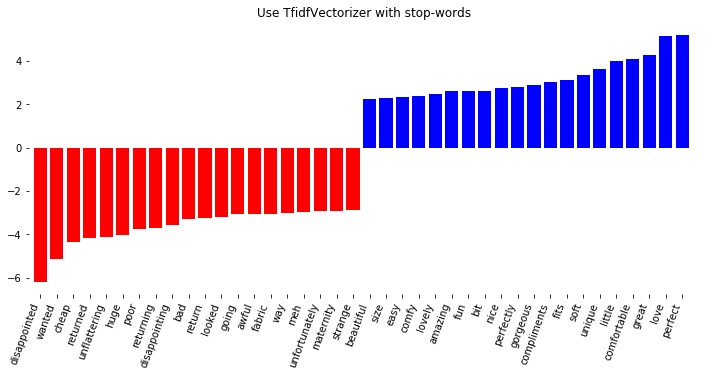

In [34]:
pipe_tfidf_sw.fit(train['Both'], y_train)
coef = pipe_tfidf_sw.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf_sw.named_steps['tfidfvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use TfidfVectorizer with stop-words");

From the results above, we can see that the AUC score decreased compared to the score of using TfidfVectorizer without stop-words, while the most important features as well as their coefficients didn't change much. So standard English stop-words didn't help.

### 2.4

Since using TfidfVectorizer without stop-words is the best model so far, let's try limiting the vocabulary using min_df or max_df based on this model.

In [35]:
pipe_tfidf_min = make_pipeline(TfidfVectorizer(min_df = 4), LogisticRegression(), memory="cache_folder")
print("AUC score for TfidfVectorizer with min_df = 4: ", np.mean(cross_val_score(pipe_tfidf_min, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for TfidfVectorizer with min_df = 4:  0.947451015824


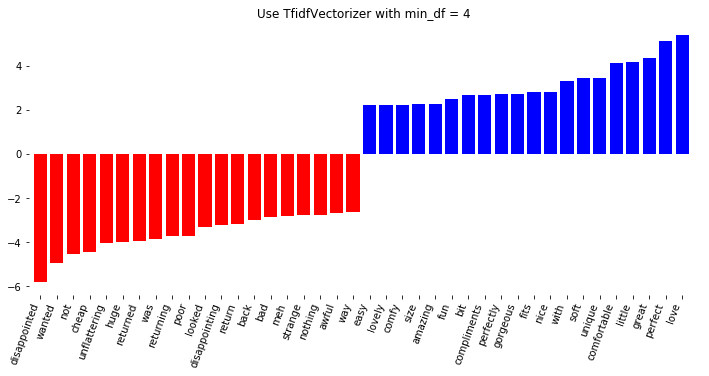

In [36]:
pipe_tfidf_min.fit(train['Both'], y_train)
coef = pipe_tfidf_min.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf_min.named_steps['tfidfvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use TfidfVectorizer with min_df = 4");

In [37]:
print("Vocabulary size without min_df: ", len(pipe_tfidf.named_steps['tfidfvectorizer'].vocabulary_))
print("Vocabulary size with min_df = 4: ", len(pipe_tfidf_min.named_steps['tfidfvectorizer'].vocabulary_))

Vocabulary size without min_df:  12997
Vocabulary size with min_df = 4:  4959


With min_df = 4, the number of features decreased to 40% of the number of features before limiting vocabulary, and the AUC score increased a little compared to the highest score we obtained in 2.1.

In [38]:
pipe_tfidf_max = make_pipeline(TfidfVectorizer(max_df = 0.5), LogisticRegression(), memory="cache_folder")
print("AUC score for TfidfVectorizer with max_df = 0.5: ", np.mean(cross_val_score(pipe_tfidf_max, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for TfidfVectorizer with max_df = 0.5:  0.947414495507


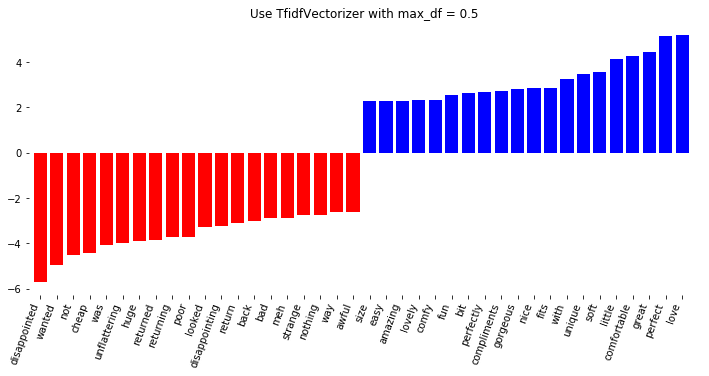

In [39]:
pipe_tfidf_max.fit(train['Both'], y_train)
coef = pipe_tfidf_max.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf_max.named_steps['tfidfvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("Use TfidfVectorizer with max_df = 0.5");

In [40]:
print("Vocabulary size without max_df: ", len(pipe_tfidf.named_steps['tfidfvectorizer'].vocabulary_))
print("Vocabulary size with max_df = 0.5: ", len(pipe_tfidf_max.named_steps['tfidfvectorizer'].vocabulary_))

Vocabulary size without max_df:  12997
Vocabulary size with max_df = 0.5:  12989


With max_df = 0.5, the number of features was only 8 less than the number of features before limiting vocabulary, but the AUC score also increased compared to the score in 2.1 and was very close to the score we got with min_df = 4.

Evaluate the best model using the test set

From above, our best model is using TfidfVectorizer without stop-words while limiting the vocabulary using min_df = 4

In [41]:
y_pred = pipe_tfidf_min.predict_proba(test['Both'])[:, 1]
print("AUC score of test set using best model: ", roc_auc_score(y_test, y_pred))

AUC score of test set using best model:  0.941823002486


## Task 3 n-grams

Our current best model is using TfidfVectorizer without stop-words while limiting the vocabulary using min_df = 4, so we will use this model for task 3.1

### 3.1

In [42]:
%%time
for ngram_range in [(1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]:
    pipe_tfidf_ngram = make_pipeline(TfidfVectorizer(min_df = 4,  ngram_range = ngram_range), LogisticRegression(), memory="cache_folder")
    print("AUC score for TfidfVectorizer with n-grams {}: {}".format(ngram_range, np.mean(cross_val_score(pipe_tfidf_ngram, train['Both'], y_train, scoring = 'roc_auc', cv = 5))))

AUC score for TfidfVectorizer with n-grams (1, 1): 0.9474510158244567
AUC score for TfidfVectorizer with n-grams (1, 2): 0.9516348857526957
AUC score for TfidfVectorizer with n-grams (1, 3): 0.9505437286341165
AUC score for TfidfVectorizer with n-grams (1, 4): 0.9500237415592421
AUC score for TfidfVectorizer with n-grams (2, 2): 0.9379389818485798
AUC score for TfidfVectorizer with n-grams (2, 3): 0.9368649107758273
CPU times: user 3min 22s, sys: 6.3 s, total: 3min 28s
Wall time: 3min 29s


From the results above, we can see that ngram_range = (1, 2) provided the best performance.

In [43]:
# visualizing only the higher-order n-grams that are important
pipe_tfidf_12 = make_pipeline(TfidfVectorizer(min_df = 4,  ngram_range = (1, 2)), LogisticRegression(), memory="cache_folder")
pipe_tfidf_12.fit(train['Both'], y_train)
coef = pipe_tfidf_12.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf_12.named_steps['tfidfvectorizer'].get_feature_names())

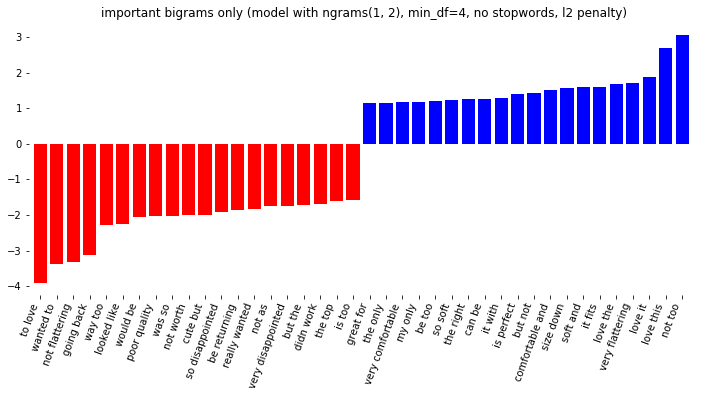

In [44]:
bi = np.array([len(feature.split(" ")) for feature in features]) == 2 
plt.figure(figsize=(12, 5))
plot_important_features(coef[bi], features[bi], rotation=70)
plt.title("important bigrams only (model with ngrams(1, 2), min_df=4, no stopwords, l2 penalty)");

### 3.2

In [45]:
pipe_tfidf_char = make_pipeline(TfidfVectorizer(min_df = 4,  ngram_range = (3, 4), analyzer="char"), LogisticRegression(), memory="cache_folder")
print("AUC score for TfidfVectorizer using character n-grams(3, 4): ", np.mean(cross_val_score(pipe_tfidf_char, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for TfidfVectorizer using character n-grams(3, 4):  0.947934798078


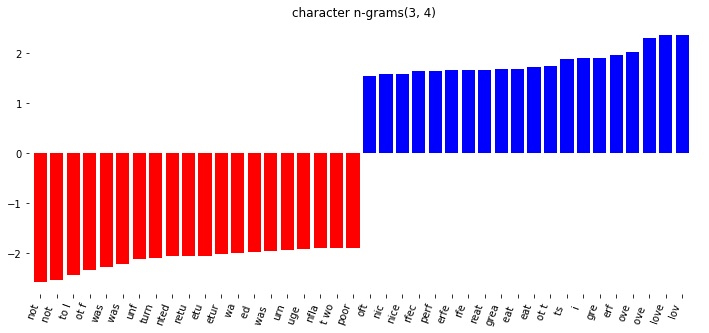

In [46]:
pipe_tfidf_char.fit(train['Both'], y_train)
coef = pipe_tfidf_char.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf_char.named_steps['tfidfvectorizer'].get_feature_names())

plt.figure(figsize=(12, 5))
plot_important_features(coef, features, rotation=70)
plt.title("character n-grams(3, 4)");

From the graph we can see that the letter combinations with the negatice coefficients are corresponding to the words "not", "was", "return", "poor" and so on, while those with the positive coefficients are corresponding to the words "nice", "perfect", "great", "love" and so on. And we can clearly see that these combinations are kind of redundant since one word can have several letter combinations.

### 3.3

From 3.1, we know that using n-grams(1, 2) would provide the best performance, so we will use this n-grams range in task 3.3

In [47]:
#pipe_tfidf_12 = make_pipeline(TfidfVectorizer(min_df = 4,  ngram_range = (1, 2)), LogisticRegression(), memory="cache_folder")
pipe_tfidf_nodf = make_pipeline(TfidfVectorizer(ngram_range = (1, 2)), LogisticRegression(), memory="cache_folder")
print("AUC score for TfidfVectorizer using n-grams(1, 2) without min_df: ", np.mean(cross_val_score(pipe_tfidf_nodf, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for TfidfVectorizer using n-grams(1, 2) without min_df:  0.950099759297


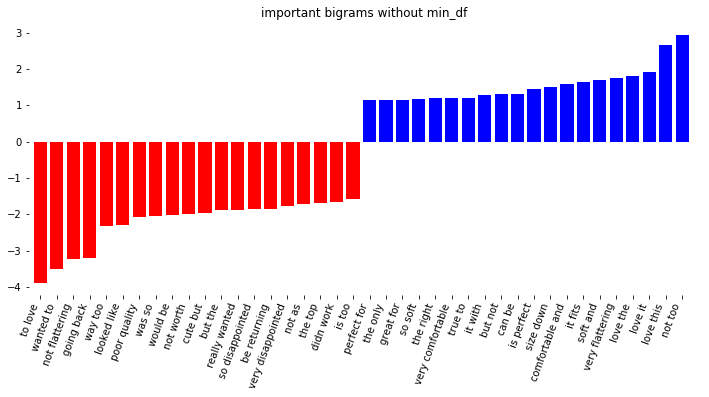

In [48]:
pipe_tfidf_nodf.fit(train['Both'], y_train)
coef = pipe_tfidf_nodf.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf_nodf.named_steps['tfidfvectorizer'].get_feature_names())

bi = np.array([len(feature.split(" ")) for feature in features]) == 2
plt.figure(figsize=(12, 5))
plot_important_features(coef[bi], features[bi], rotation=70)
plt.title("important bigrams without min_df");

In [49]:
pipe_tfidf_nodf.fit(train['Both'], y_train)
print("Vocabulary size of n-grams(1, 2) without min_df: ", len(pipe_tfidf_nodf.named_steps['tfidfvectorizer'].vocabulary_))
print("Vocabulary size of n-grams(1, 2) with min_df = 4: ", len(pipe_tfidf_12.named_steps['tfidfvectorizer'].vocabulary_))

Vocabulary size of n-grams(1, 2) without min_df:  208485
Vocabulary size of n-grams(1, 2) with min_df = 4:  36399


We can see that, using min_df = 4 reduced the the number of features to less than 20% of the original and increased the score at the same time.

In [50]:
pipe_tfidf_12sw = make_pipeline(TfidfVectorizer(min_df = 4, ngram_range = (1, 2), stop_words="english"), LogisticRegression(), memory="cache_folder")
print("AUC score for TfidfVectorizer using n-grams(1, 2), min_df = 4 and stopwords", np.mean(cross_val_score(pipe_tfidf_12sw, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for TfidfVectorizer using n-grams(1, 2), min_df = 4 and stopwords 0.942545337878


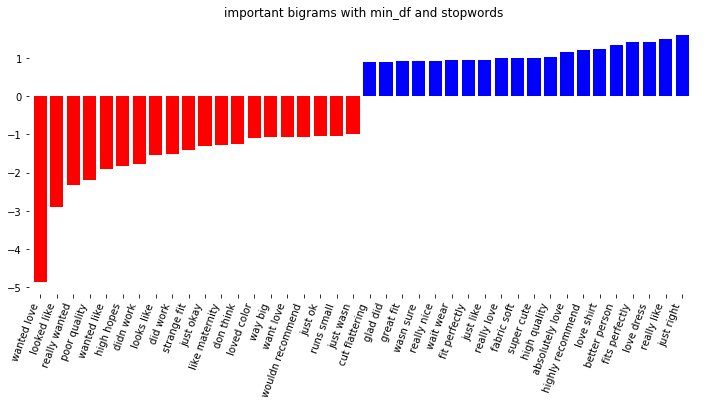

In [51]:
pipe_tfidf_12sw.fit(train['Both'], y_train)
coef = pipe_tfidf_12sw.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf_12sw.named_steps['tfidfvectorizer'].get_feature_names())

bi = np.array([len(feature.split(" ")) for feature in features]) == 2
plt.figure(figsize=(12, 5))
plot_important_features(coef[bi], features[bi], rotation=70)
plt.title("important bigrams with min_df and stopwords");

In [52]:
pipe_tfidf_12sw.fit(train['Both'], y_train)
print("Vocabulary size of n-grams(1, 2) with min_df = 4 and stopwords: ", len(pipe_tfidf_12sw.named_steps['tfidfvectorizer'].vocabulary_))

Vocabulary size of n-grams(1, 2) with min_df = 4 and stopwords:  22573


We can see that the number of features decreased again after using the stopwords, which is approximately 10% of the original number of features when we didn't do anything. But the score decreased a little this time, which is less than the score when we didn't do anything.

Evaluate the best model using the test set

From above, our best model is using TfidfVectorizer without stop-words while limiting the vocabulary using min_df = 4 on n-grams(1, 2).

In [53]:
y_pred = pipe_tfidf_12.predict_proba(test['Both'])[:, 1]
print("AUC score of test set using best model: ", roc_auc_score(y_test, y_pred))

AUC score of test set using best model:  0.94891561787


## Task 4 Model Tuning

From task3, we know that the n-grams(1, 2) performed best and the best model is using TfidfVectorizer without using stopwords while limiting the vocabulary using min_df = 4. So these are what we will use in task 4.

In [54]:
print("AUC score for using n-grams(1, 2) with l2 penalty: ", np.mean(cross_val_score(pipe_tfidf_12, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for using n-grams(1, 2) with l2 penalty:  0.951634885753


In [55]:
pipe_tfidf_l1 = make_pipeline(TfidfVectorizer(min_df = 4,  ngram_range = (1, 2)), LogisticRegression(penalty="l1"), memory="cache_folder")
print("AUC score for using n-grams(1, 2) with l1 penalty: ", np.mean(cross_val_score(pipe_tfidf_l1, train['Both'], y_train, scoring = 'roc_auc', cv = 5)))

AUC score for using n-grams(1, 2) with l1 penalty:  0.943741462546


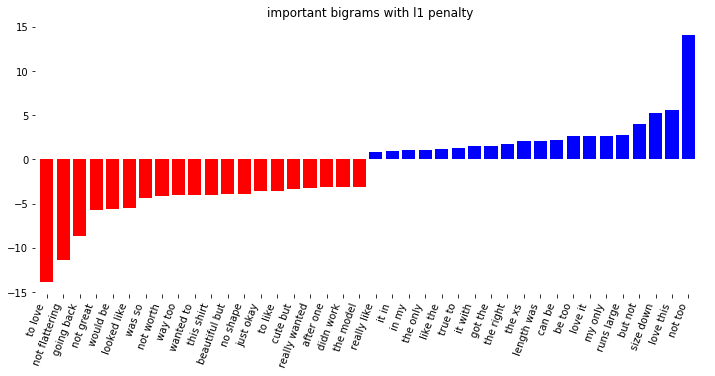

In [56]:
pipe_tfidf_l1.fit(train['Both'], y_train)
coef = pipe_tfidf_l1.named_steps['logisticregression'].coef_.ravel()
features = np.array(pipe_tfidf_l1.named_steps['tfidfvectorizer'].get_feature_names())

bi = np.array([len(feature.split(" ")) for feature in features]) == 2
plt.figure(figsize=(12, 5))
plot_important_features(coef[bi], features[bi], rotation=70)
plt.title("important bigrams with l1 penalty");

We can see that the performance with l2 penalty is better. But the absolute values of coefficients with l1 penalty are larger than those with l2 penalty, especially the most two importance bigram features.

Evaluate the best model using the test set

From above, our best model is still using TfidfVectorizer without stop-words while limiting the vocabulary using min_df = 4 on n-grams(1, 2).

In [57]:
y_pred = pipe_tfidf_12.predict_proba(test['Both'])[:, 1]
print("AUC score of test set using best model: ", roc_auc_score(y_test, y_pred))

AUC score of test set using best model:  0.94891561787


We can try things like this:

a) change the token pattern regex

b) use stemming or lemmatization

c) define our own stopwords

d) use LSA with Truncated SVD

e) use LatentDirichletAllocation